In [ ]:
!ls

# 1. Data Preperation

## 1.1 Preperation
Load packages:

In [ ]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
from sklearn.cluster import KMeans

from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import pickle

#Read original data and save it to h5ad
from scanpy import read_10x_h5

# for countour cutting
import cv2 as cv
from skimage import io

In [ ]:
%cd /lustre03/project/6075067/calcium/2021/CeLEry

In [ ]:
import sys
sys.path.append('/lustre03/project/6075067/calcium/2021/CeLEry/CeLEry_package')

import CeLEry as cel
cel.__version__

## 1.2 Load Data

In [ ]:
from data.Mouse2D.MP1_SVG import d_g


### Load MouseBarin Data Section 1: Regarded as Spatial Transcriptomic Data
dataSection1full = sc.read("data/MouseBrain/MP1_sudo.h5ad")
genename = dataSection1full.var['genename']


# Get the gene list from the pre-screening
genelistlist = [d_g[i] for i in  range(len(d_g))]  # transform dictionary to a list of lists
genelist = sum(genelistlist, [])  # merge the list of lists
genelistuni = list( dict.fromkeys(genelist) )   # remove duplicates

genelistindex = [genename[genename == i].index[0] for i in genelistuni if  len(genename[genename == i])>0]


In [ ]:
## Take the subset of dataSection1
xcords = dataSection1full.obs["x"].to_numpy()
ycords = dataSection1full.obs["y"].to_numpy()

Section1Sub = dataSection1full[(xcords>=3000) & (xcords<7000) & (ycords>=6200) & (ycords<10500), genelistindex]
Section1Sub.obs = Section1Sub.obs/50
Section1Sub.obs = Section1Sub.obs.astype(int)
Section1Sub.obs["inner"] = 0

In [ ]:
#Read in hitology image
ImageSec1=io.imread("data/MouseBrain/V1_Mouse_Brain_Sagittal_Posterior_image.tif")
ImageSec1sub = ImageSec1[3000:7000,6200:10500,:]

imgray = cv.cvtColor(ImageSec1sub, cv.COLOR_BGR2GRAY)
imgray2 = imgray.copy()
imgray2[imgray2<160] = 0
imgray2[imgray2>160] = 255

for i in range(Section1Sub.obs.shape[0]):
    xi = Section1Sub.obs["x"][i]
    yi = Section1Sub.obs["y"][i]
    subarea = np.mean(imgray2[(xi*50-3000):(xi*50+50-3000), (yi*50-6200):(yi*50+50-6200)])
    if subarea<140 or xi*50>6000:
         Section1Sub.obs["inner"].iloc[i] = 1
    if yi*50>10200 or xi*50<1000:
         Section1Sub.obs["inner"].iloc[i] = 0

Section1Sub = Section1Sub[Section1Sub.obs["inner"] == 1]


In [ ]:
## Calculating z-score
cel.get_zscore(Section1Sub)

index10 = np.load("output/CeLEry/index10.npy")
index30 = np.load("output/CeLEry/index30.npy")
index50 = np.load("output/CeLEry/index50.npy")

# split the data into training and testing data

# 10% hold off
Section1train10 = Section1Sub[list(set(range(Section1Sub.shape[0]))-set(index10)),]
Section1test10 = Section1Sub[list(set(index10)),]

# 30% hold off
Section1train30 = Section1Sub[list(set(range(Section1Sub.shape[0]))-set(index30)),]
Section1test30 = Section1Sub[list(set(index30)),]

# 50% hold off
Section1train50 = Section1Sub[list(set(range(Section1Sub.shape[0]))-set(index50)),]
Section1test50 = Section1Sub[list(set(index50)),]

# 2. Data Augmentation

In [ ]:
cdata = Section1Sub.copy()
cel.getGeneImg(cdata, emptypixel = 0, obsset = ["x", "y"])
cdataexpand =  np.expand_dims(cdata.GeneImg, axis=1) 
np.save("output/CeLEry/full_geneimg.npy", cdataexpand)

cdata_train10 = Section1train10.copy()
cdata_train30 = Section1train30.copy()
cdata_train50 = Section1train50.copy()

cel.getGeneImg(cdata_train10, emptypixel = 0, obsset = ["x", "y"])
cel.getGeneImg(cdata_train30, emptypixel = 0, obsset = ["x", "y"])
cel.getGeneImg(cdata_train50, emptypixel = 0, obsset = ["x", "y"])

cdataexpand_train10 =  np.expand_dims(cdata_train10.GeneImg, axis=1) 
np.save("output/CeLEry/train10_geneimg.npy", cdataexpand_train10)
cdataexpand_train30 =  np.expand_dims(cdata_train30.GeneImg, axis=1) 
np.save("output/CeLEry/train30_geneimg.npy", cdataexpand_train30)
cdataexpand_train50 =  np.expand_dims(cdata_train50.GeneImg, axis=1) 
np.save("output/CeLEry/train50_geneimg.npy", cdataexpand_train50)


In [ ]:
Kmeans_cluster = np.load("output/CeLEry/cluster.npy")

Kmeans_cluster.max()

In [ ]:
def DataAugmentation (RefDataOrigin, obs_location = ['x_cord','y_cord'], path = "output/Project", filename = "SpatialTranscript", clusterready = False, n_clusters=100,  beta = 1e-5, nrep = 2, generateplot = True):
    #Prepare
    RefDataOriginsort = RefDataOrigin.obs.sort_values (by = obs_location)
    RefDataOrigin = RefDataOrigin[RefDataOriginsort.index]
    cdata = RefDataOrigin.copy()
    cel.getGeneImg(cdata, emptypixel = 0, obsset = obs_location)
    cdataexpand =  np.expand_dims(cdata.GeneImg, axis=1) 
    #Clustering
    try:
        os.makedirs("{path}/DataAugmentation".format(path = path))
    except FileExistsError:
        print("Folder already exists")
    if clusterready:
        kmeansresults = np.load("{path}/DataAugmentation/{filename}_cluster.npy".format(path = path, filename = filename))
    else:
        kmeansmodel =  KMeans(n_clusters, random_state=0)
        cdatacentral = centralize(cdataexpand.copy())
        direclust = [cdatacentral[x,0,:,:] for x in range(cdatacentral.shape[0])]
        direflat = [x.flat for x in direclust]
        direflatnp = np.stack(direflat)
        kmeans = kmeansmodel.fit(direflatnp)
        kmeansresults = kmeans.labels_
        np.save("{path}/DataAugmentation/{filename}_cluster.npy".format(path = path, filename = filename), kmeansresults)
    # 
    full_RefData = cel.datagenemapclust(cdataexpand, kmeansresults)
    CVAEmodel, clg = cel.FitGenModel(path = path, filename = filename, traindata = full_RefData, cdataexpand = cdataexpand, Kmeans_cluster = kmeansresults, beta = beta)
    CVAEmodel, clg = cel.FitGenModel_continue(path = path, filename = filename, model = CVAEmodel, clg = clg, traindata = full_RefData, beta = beta)
    if generateplot:
        print("Now generating the plots for the augmented data...")
        cel.GeneratePlot(path, filename, beta = beta, traindata = full_RefData)
    cel.Data_Generation(path, filename, beta= beta, dataSection1 = RefDataOrigin, traindata = full_RefData, nrep = nrep)
    


In [ ]:
def DataAugmentation2  (RefDataOrigin, obs_location = ['x_cord','y_cord'], path = "output/Project", filename = "SpatialTranscript", clusterready = False, n_clusters=100,  beta = 1e-5, nrep = 2, generateplot = True):
    #Prepare
    RefDataOriginsort = RefDataOrigin.obs.sort_values (by = obs_location)
    RefDataOrigin = RefDataOrigin[RefDataOriginsort.index]
    cdata = RefDataOrigin.copy()
    cel.getGeneImg(cdata, emptypixel = 0, obsset = obs_location)
    cdataexpand =  np.expand_dims(cdata.GeneImg, axis=1) 
    #Clustering
    try:
        os.makedirs("{path}/DataAugmentation".format(path = path))
    except FileExistsError:
        print("Folder already exists")
    if clusterready:
        kmeansresults = np.load("{path}/DataAugmentation/{filename}_cluster.npy".format(path = path, filename = filename))
    else:
        kmeansmodel =  KMeans(n_clusters, random_state=0)
        cdatacentral = centralize(cdataexpand.copy())
        direclust = [cdatacentral[x,0,:,:] for x in range(cdatacentral.shape[0])]
        direflat = [x.flat for x in direclust]
        direflatnp = np.stack(direflat)
        kmeans = kmeansmodel.fit(direflatnp)
        kmeansresults = kmeans.labels_
        np.save("{path}/DataAugmentation/{filename}_cluster.npy".format(path = path, filename = filename), kmeansresults)
    # 
    full_RefData = cel.datagenemapclust(cdataexpand, kmeansresults)
    cel.GeneratePlot(path, filename, beta = beta, traindata = full_RefData)


In [ ]:
cel.DataAugmentation(Section1Sub.copy(), obs_location = ["x", "y"], path = "output/CeLEry", filename = "full",  beta = 1e-6, clusterready = True)

In [ ]:
cel.DataAugmentation2(Section1Sub.copy(), obs_location = ["x", "y"], path = "output/CeLEry", filename = "full",  beta = 1e-6, clusterready = True)

In [ ]:
cel.DataAugmentation2(Section1Sub.copy(), obs_location = ["x", "y"], path = "output/CeLEry", filename = "full",  beta = 1e-7, clusterready = True)

In [ ]:
## Get average plot for the cluster genes
Kmeans_cluster = np.load("output/CeLEry/cluster.npy")

Kmeans_cluster.max()

In [79]:
Kmeans_cluster[134]

30

-2.6840672

100%|██████████| 3/3 [00:00<00:00,  8.49it/s]


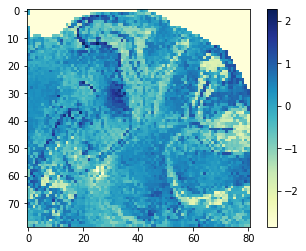

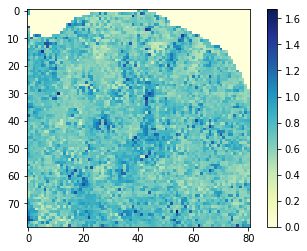

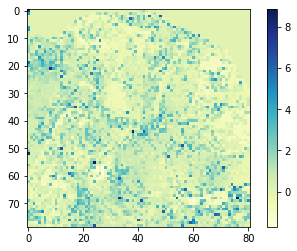

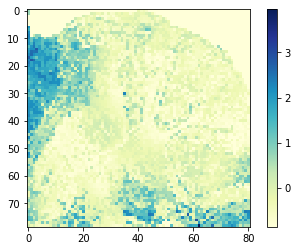

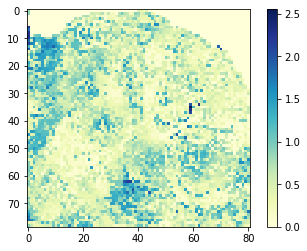

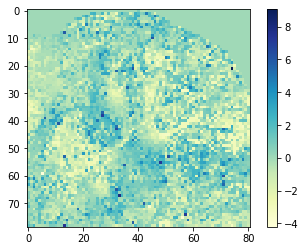

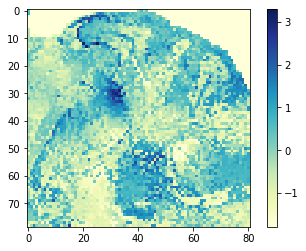

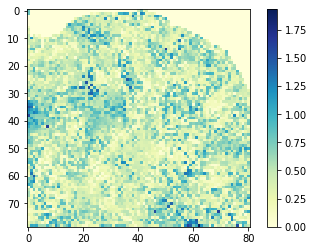

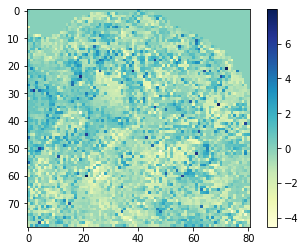

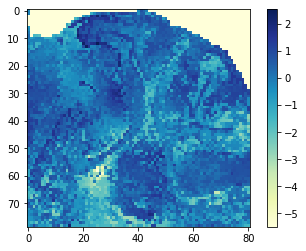

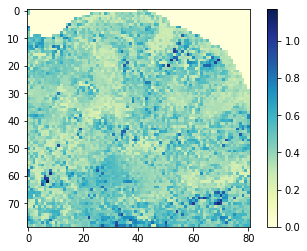

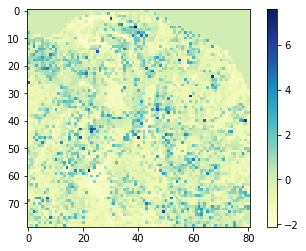

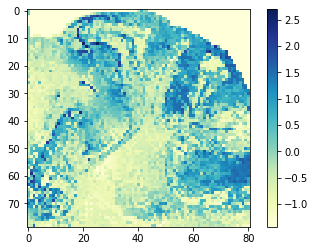

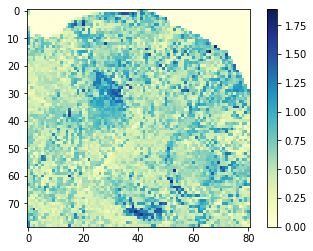

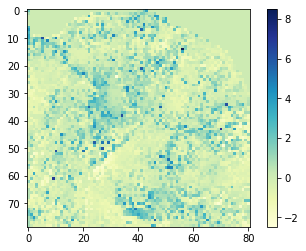

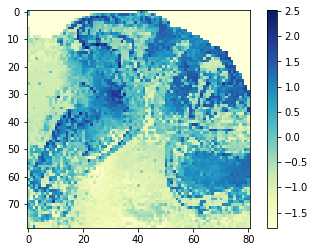

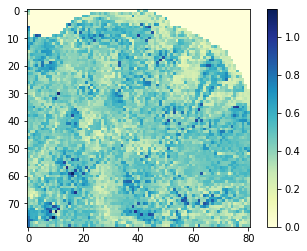

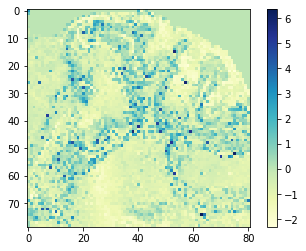

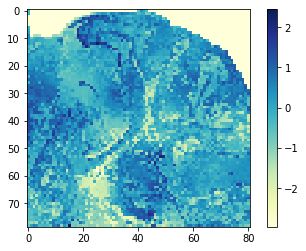

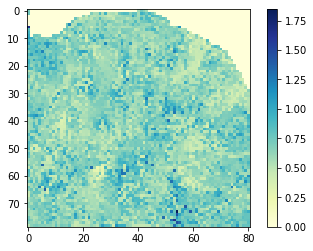

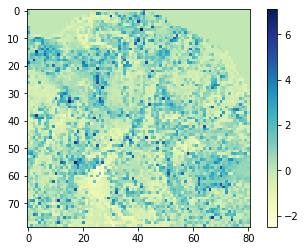

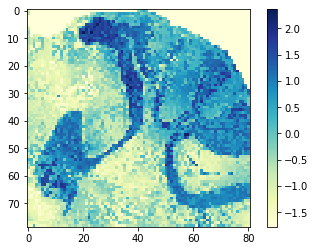

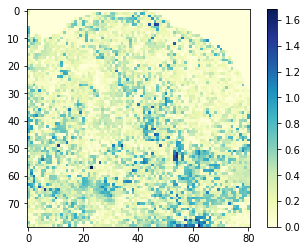

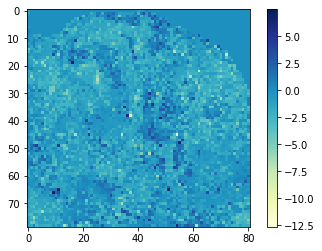

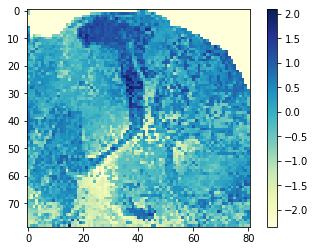

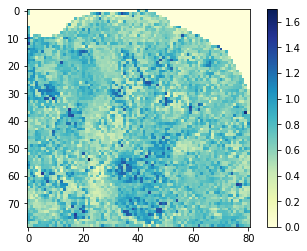

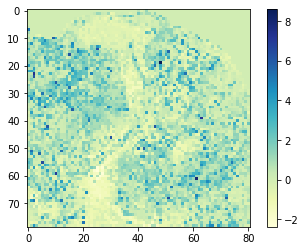

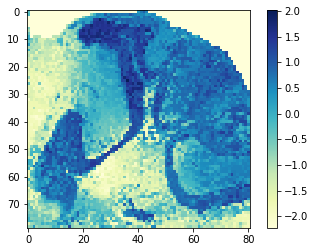

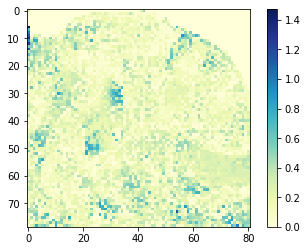

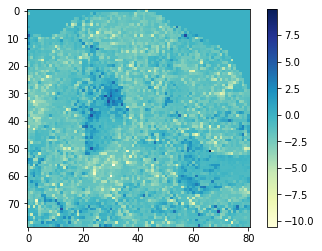

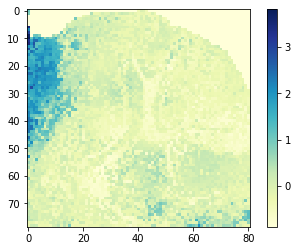

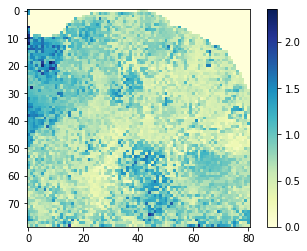

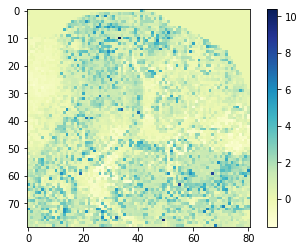

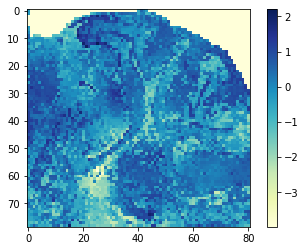

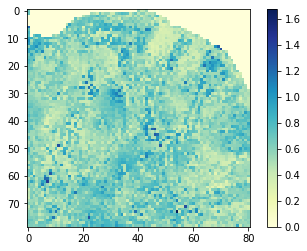

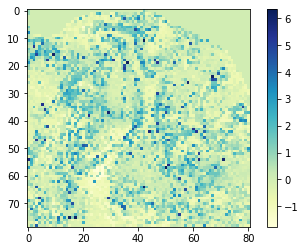

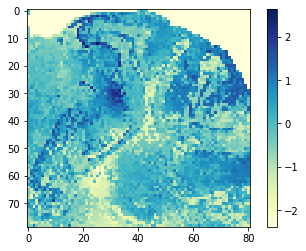

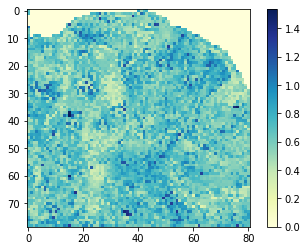

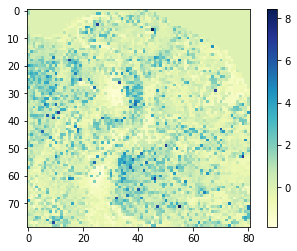

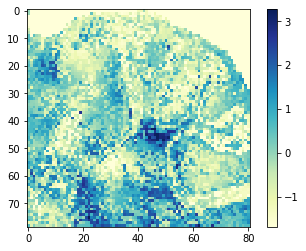

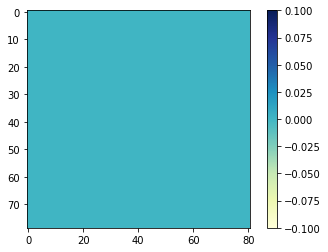

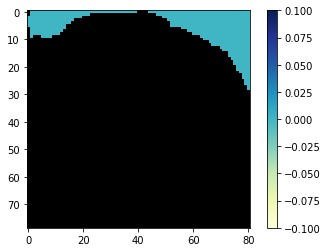

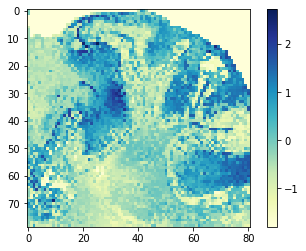

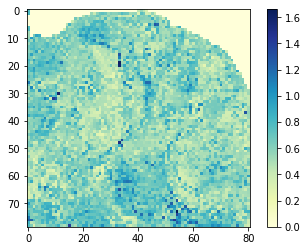

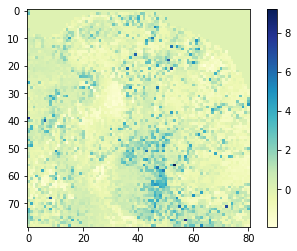

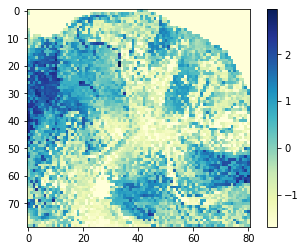

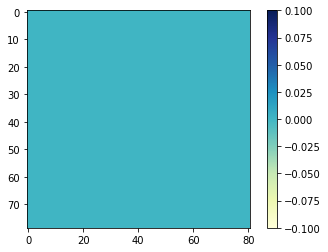

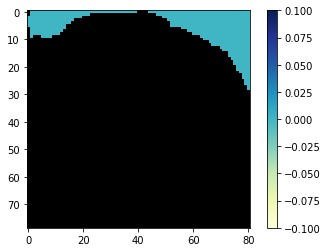

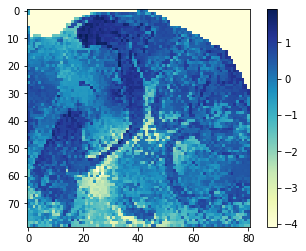

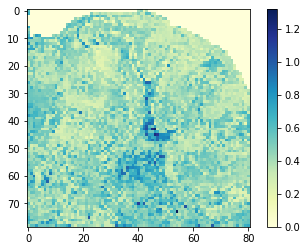

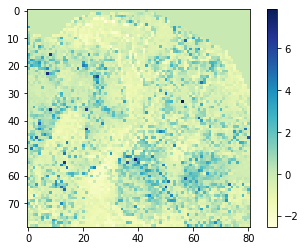

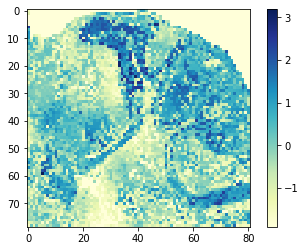

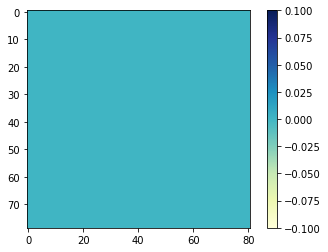

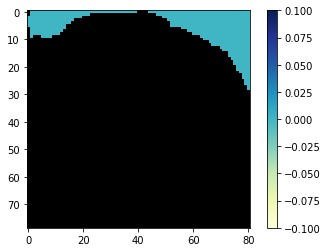

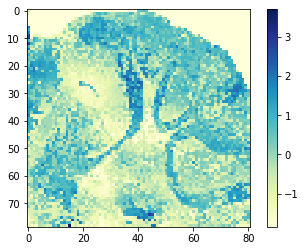

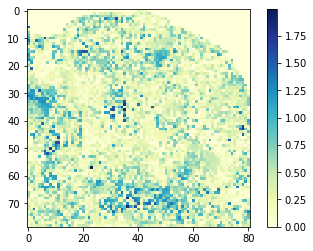

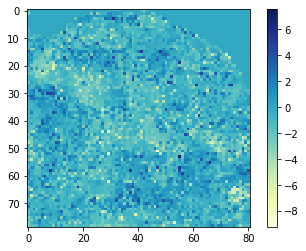

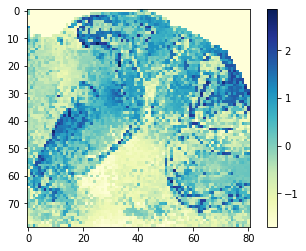

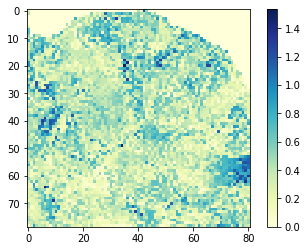

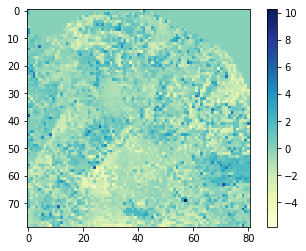

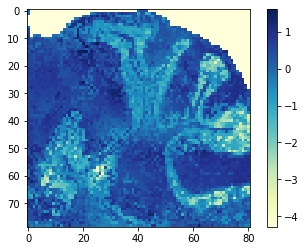

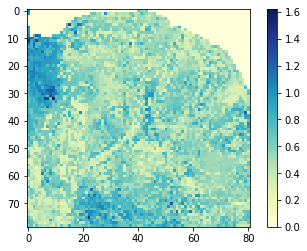

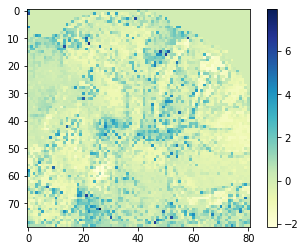

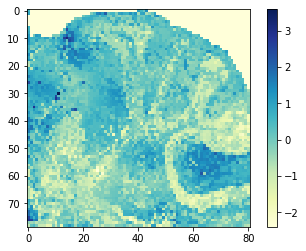

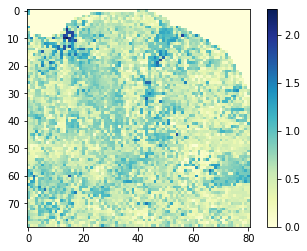

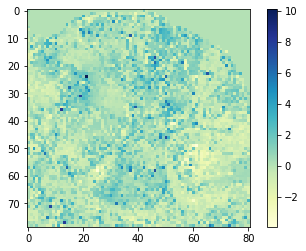

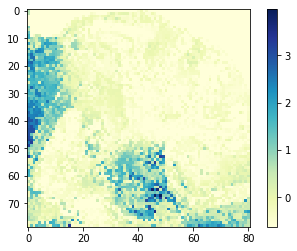

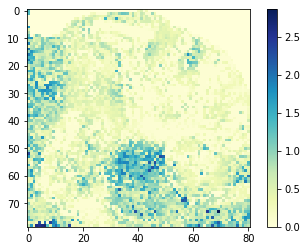

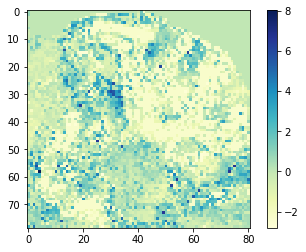

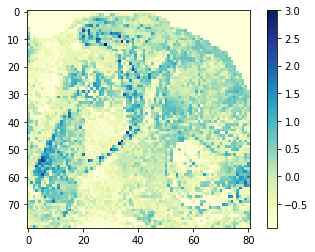

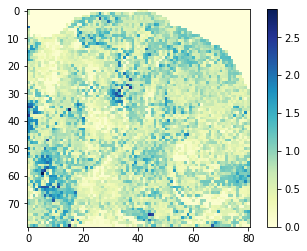

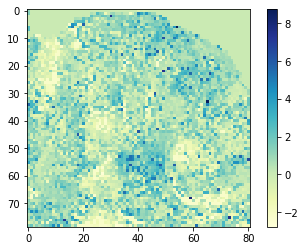

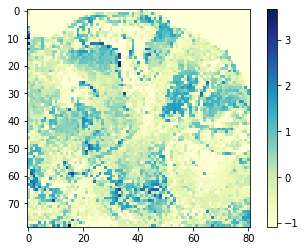

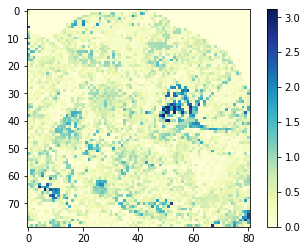

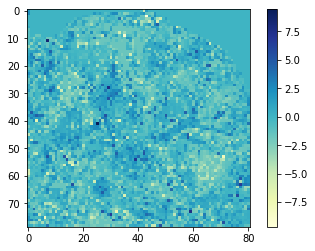

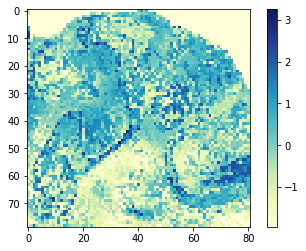

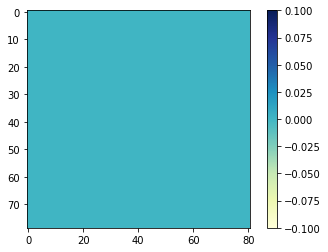

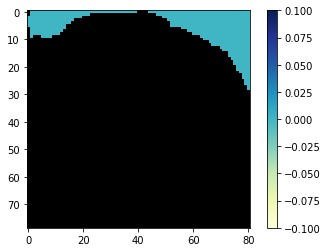

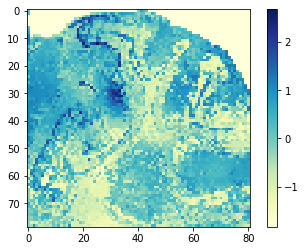

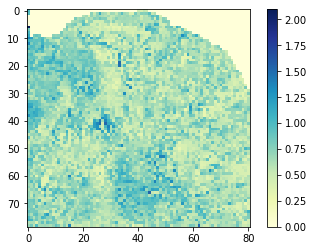

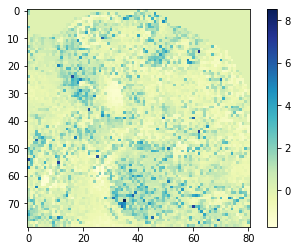

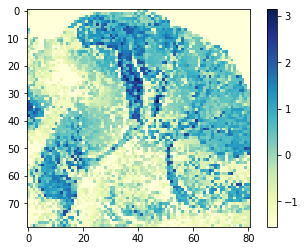

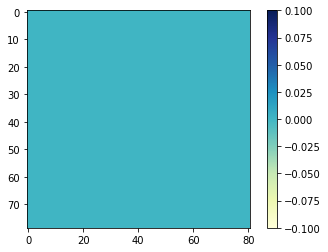

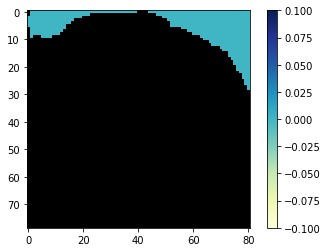

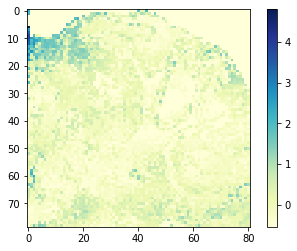

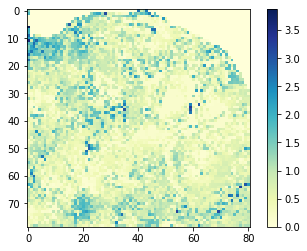

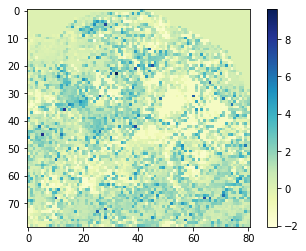

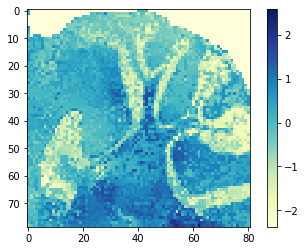

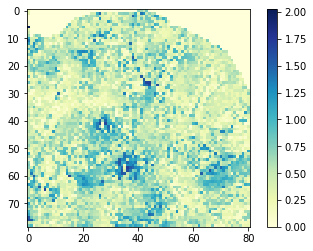

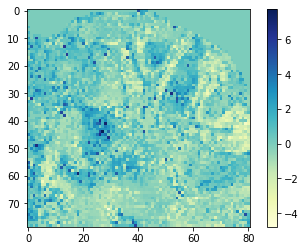

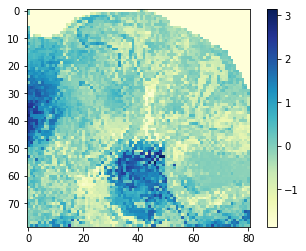

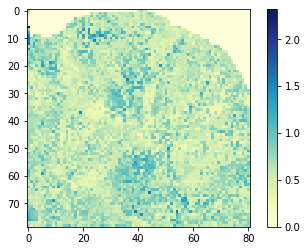

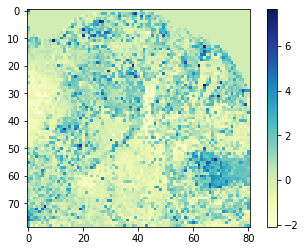

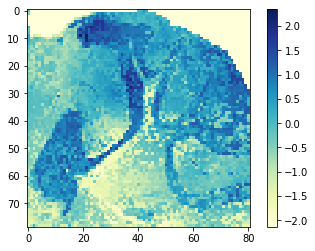

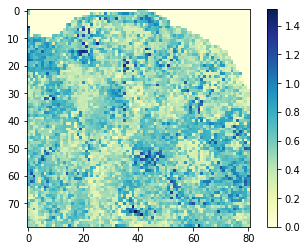

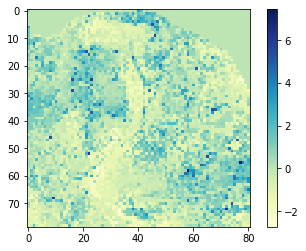

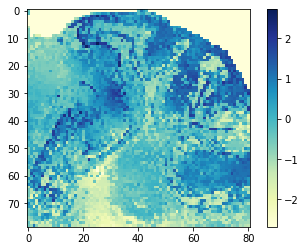

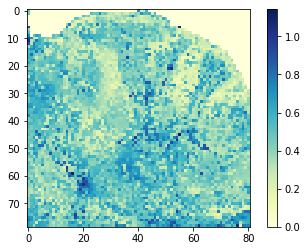

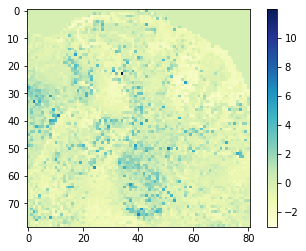

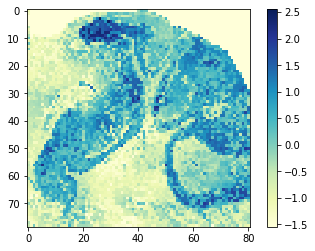

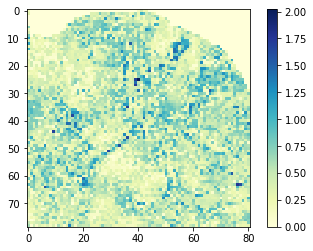

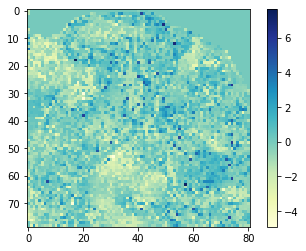

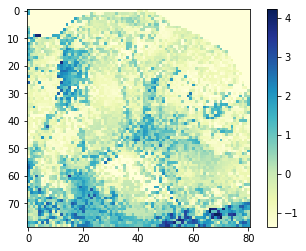

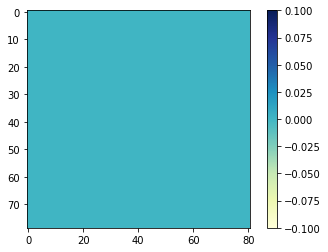

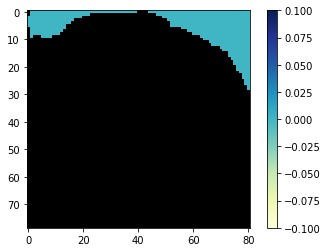

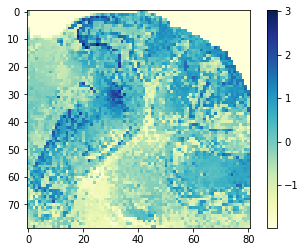

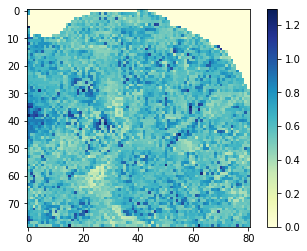

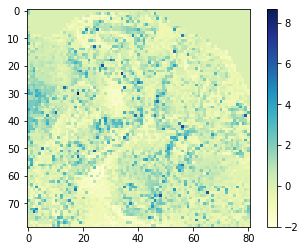

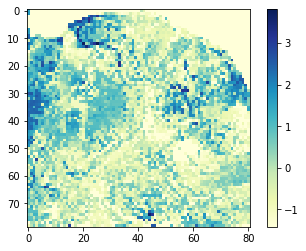

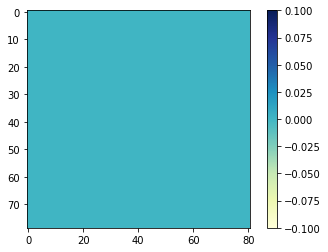

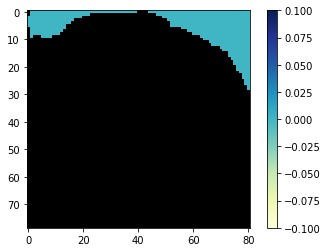

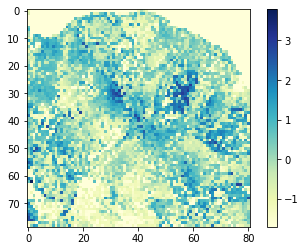

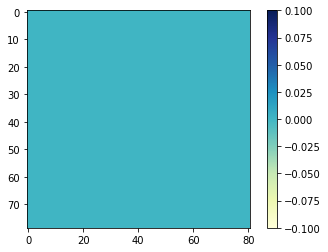

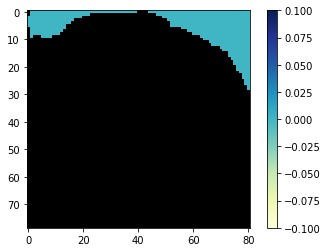

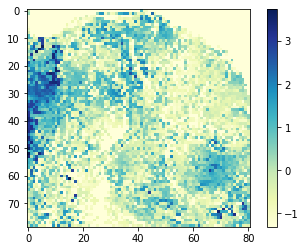

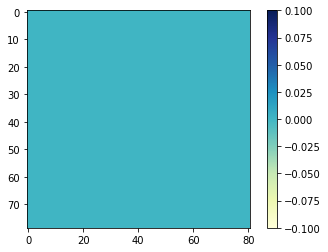

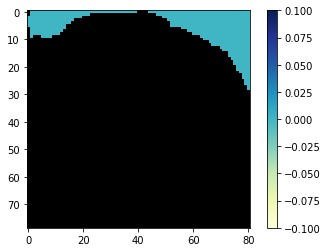

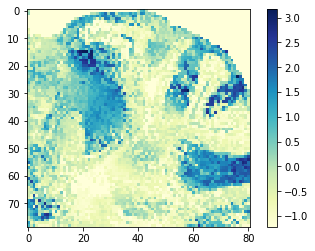

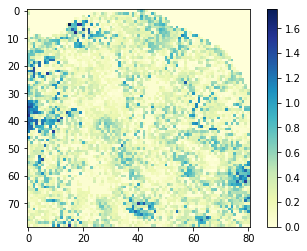

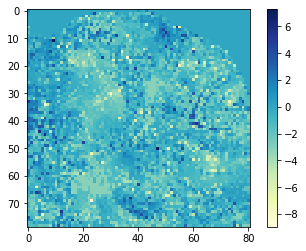

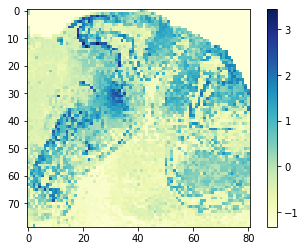

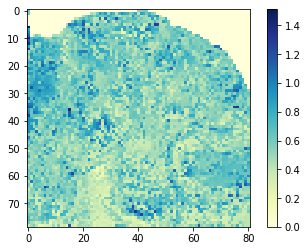

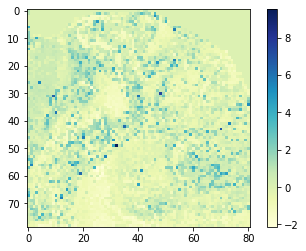

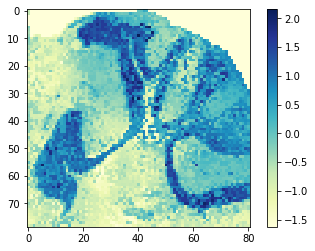

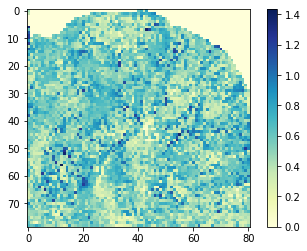

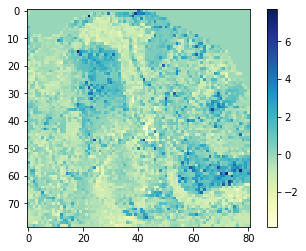

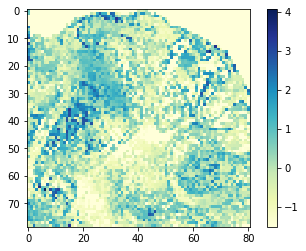

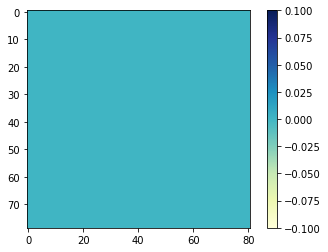

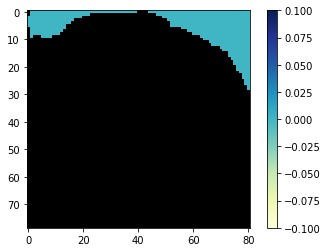

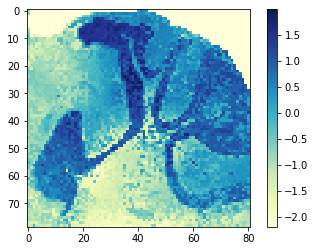

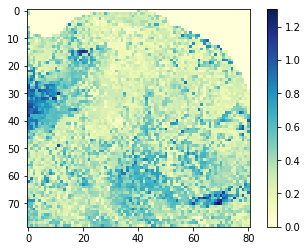

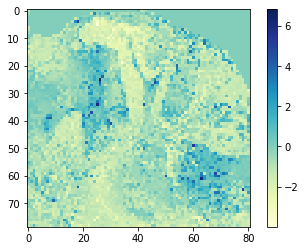

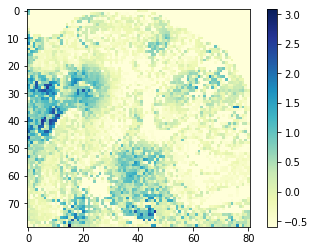

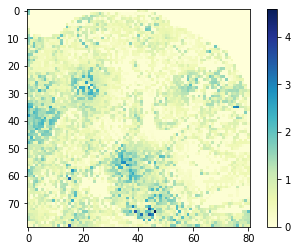

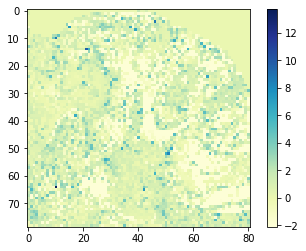

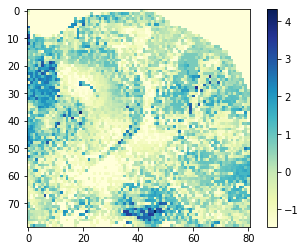

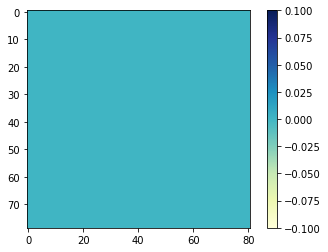

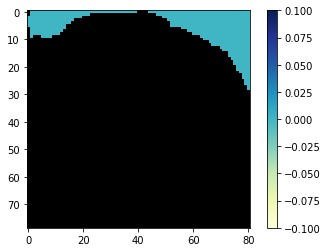

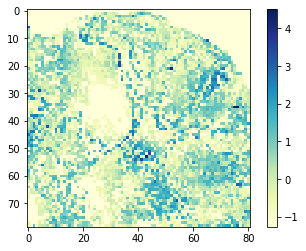

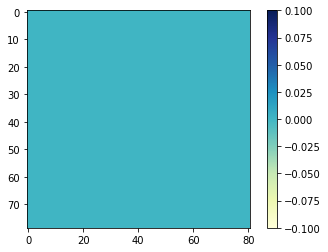

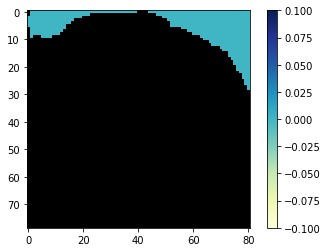

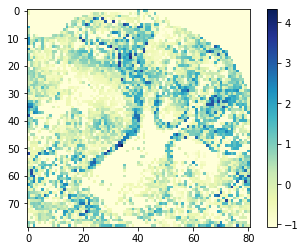

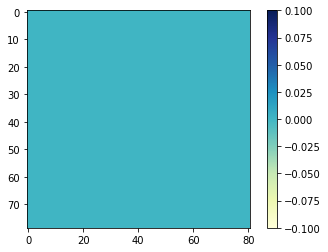

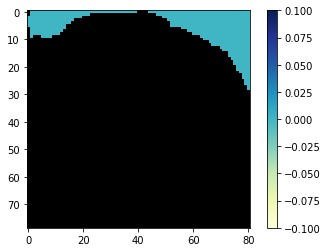

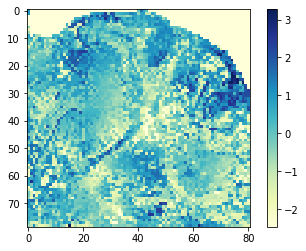

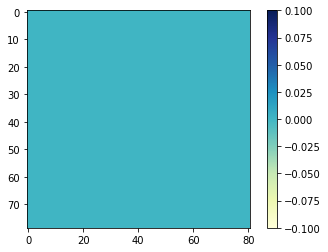

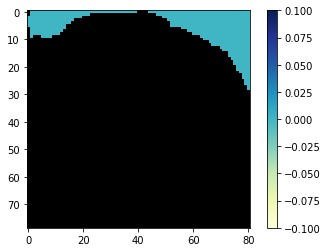

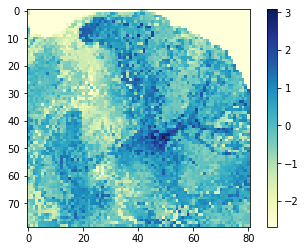

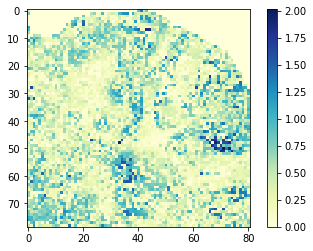

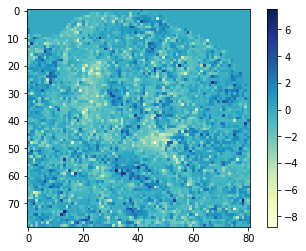

In [82]:
for i in range(50):
    subset_geme = [ x == i for x in Kmeans_cluster ]
    avg_expr_df = pd.DataFrame( {"avg": np.mean(Section1Sub.X[:,subset_geme], axis=1),
                            "std": np.std(Section1Sub.X[:,subset_geme], axis=1),
                            "std_over_absmean": np.log(np.std(Section1Sub.X[:,subset_geme], axis=1)/np.abs(np.mean(Section1Sub.X[:,subset_geme], axis=1)))})
    avd_expr_anndata = sc.AnnData(avg_expr_df,
                        Section1Sub.obs)
    cel.getGeneImg(avd_expr_anndata, emptypixel = avg_expr_df["avg"].min(), obsset = ["x", "y"])
    clusterid = i
    cel.plotGeneImg(avd_expr_anndata.GeneImg[0,:,:], filename = "output/CeLEry/DataAugmentation/clustermean/cluster_{clusterid}_mean".format(clusterid = clusterid))
    cel.getGeneImg(avd_expr_anndata, emptypixel = 0, obsset = ["x", "y"])
    cel.plotGeneImg(avd_expr_anndata.GeneImg[1,:,:], filename = "output/CeLEry/DataAugmentation/clustermean/cluster_{clusterid}_sd".format(clusterid = clusterid))
    cel.plotGeneImg(avd_expr_anndata.GeneImg[2,:,:], filename = "output/CeLEry/DataAugmentation/clustermean/cluster_{clusterid}_cv".format(clusterid = clusterid))

    